In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def unit_step(n):
    return zero(n) if n < 0 else 1
    
def impulse(n):
    return zero(n) if n != 0 else 1

def const(a):
    return lambda n: a

def zero(n):
    return 0

def power_signal(gamma):
    return lambda n: gamma**n

def sinc(arg):
    return lambda n: 1 if n == 0 else np.sin(arg * n)/(arg * n)

def dirichlet(N, arg):
    return lambda n: (-1)**(n*(N-1)) if np.sin(arg*n/2) == 0 else np.sin(N*n*arg/2)/(N*np.sin(arg*n/2))

def rect(duty_cycle=0.5, amp=1, period=2, count=1, dc_offset=0, t_offset=0):
    if count <= 0:
        return lambda n: amp + dc_offset if (n - t_offset) % period < period * duty_cycle else dc_offset
    return lambda n: dc_offset if abs((n - t_offset) / period) >=+ count else (
        amp + dc_offset if (n + t_offset) % period < period * duty_cycle else dc_offset
    )

def gen_signal( start, end, signal=zero, bk=[] ):
    """Returns a tuple with a lambda function and a range. bk or signal or both can be specified."""
    if(end-start == len(bk) and start < 0):
        bk = bk[-start:]
    return [lambda n: signal(n) + sum([impulse(n-k)*bk[k] for k in range(len(bk))]), 
            (start, end)]

def convolve(x1,x2):
    """Returns the signal x1 convolved with x2. This will work for two FIR signals, and if x1 has infinite duration,
    but not if both are infinite duration."""
    # x1 * x2 = sum(x1[n-k]*x2[n] for k = 0 to len(x1)) for x = 0 to len(x2)
    start = min(x1[1][0], x2[1][0])
    end   = max(x1[1][1], x2[1][1])
    return gen_signal(start, end,
                      signal = lambda n: sum( [x1[0](n-k)*x2[0](k) for k in range(start, end)] ) 
                     )

def DTFT(signal, num_pts = 100):
    begin = signal[1][0]
    end = signal[1][1]
    
    x = np.linspace(-np.pi, np.pi, num=num_pts)
    real = np.array([sum([signal[0](n) * np.cos(n*w) for n in range(begin, end)]) for w in x])
    im = np.array([sum([signal[0](n) * np.sin(n*w) for n in range(begin,end)]) for w in x])
    
    mag = np.sqrt((real**2 + im**2))
    phase = np.arctan2(im,real)
    
    #normalize phase to [-pi, pi)
    phase = (phase)%(2*np.pi) - np.pi
            
    plt.figure()
    plt.subplot(2,1,1)
    plt.ylabel('Magnitude')
    plt.xlim(-np.pi, np.pi)
    plt.ylim(bottom = -0.05*max(mag), top = max(max(mag),2)*1.05)
    plt.plot(x,mag)
    
    plt.subplot(2,1,2)
    plt.ylabel('Phase')
    plt.xlim(-np.pi, np.pi)
    plt.ylim(bottom = -np.pi*1.05, top = np.pi*1.05)
    plt.plot(x,phase)
    plt.show()
    
def change_range(signal, new_start, new_end):
    signal[1] = (new_start,new_end)
    
def time_shift(signal, t0):
    return [ lambda n: signal(n - t0), (signal[1][0], signal[1][1])]
    
def add_signals(signal1, signal2):
    start = min(signal1[1][0], signal2[1][0])
    end = max(signal1[1][1], signal2[1][1])
    sig_sum = lambda n: signal1[0](n - signal1[1][0]) + signal2[0](n - signal2[1][0])
    return gen_signal(start, end, signal=sig_sum)
    
def graph_signal(signal):
    x = np.linspace(signal[1][0], signal[1][1]-1, 
                    num=(signal[1][1] - signal[1][0]))
    y = [signal[0](i) for i in x]
    plt.figure()
    plt.ylabel('Magnitude')
    plt.xlabel('n')
    plt.stem(x,y)
    plt.show()
    
def print_signal(signal):
    print('n | x[n]')
    for k in range(signal[1][0], signal[1][1]+1):
        print("{}\t|\t{}".format(k, round(signal[0](k),2)))
        
def save_signal(signal, filename):
    with open(filename, "w+") as file:
        file.write("n,x[n]\n")
        for k in range(signal[1][0], signal[1][1]+1):
            file.write("{},{}\n".format(k,signal[0](k)))

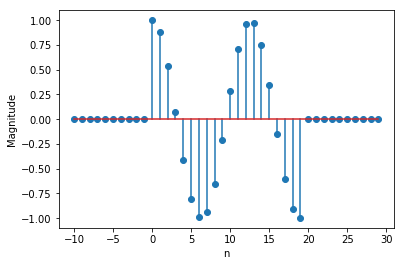

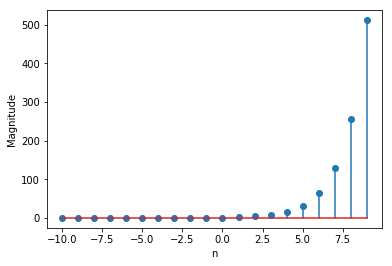

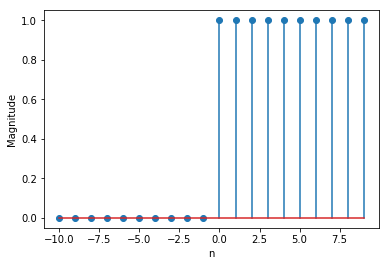

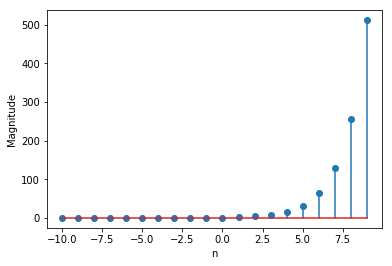

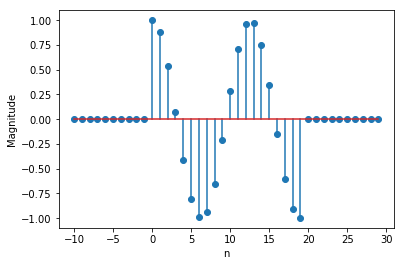

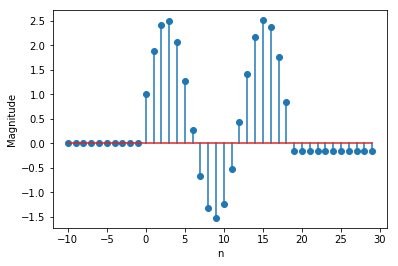

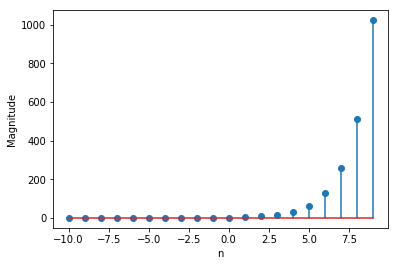

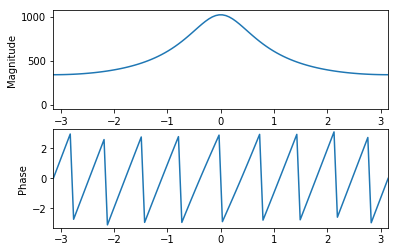

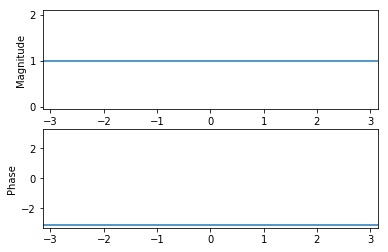

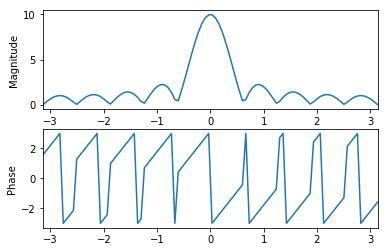

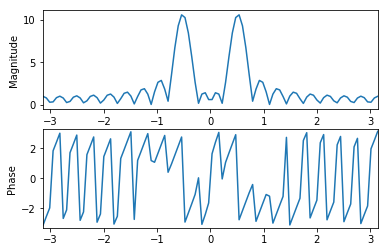

In [2]:
u = gen_signal(-10,10,signal=unit_step)
i = gen_signal(-10,10,signal=impulse)
q = lambda n: zero(n) if n < 0 else np.cos(n/2) if n < 20 else zero(n)
qq = gen_signal(-10,30,q)
ps = gen_signal(-10,10, power_signal(2))
cv = convolve(u,i)

graph_signal(qq)
graph_signal(ps)
graph_signal(convolve(u,i))
graph_signal(convolve(i,ps))
graph_signal(convolve(i,qq))
graph_signal(convolve(u,qq))
graph_signal(convolve(u,ps))
DTFT(ps)
DTFT(i)
DTFT(u)
DTFT(qq)

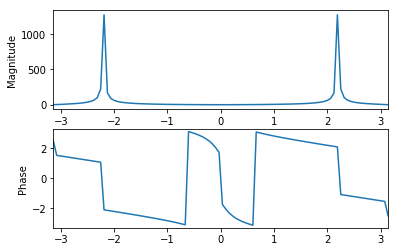

In [3]:
z = gen_signal(0,0,lambda n: 15*np.cos(0.7 * np.pi * n + np.pi/3))
change_range(z, -100,100)
DTFT(z)

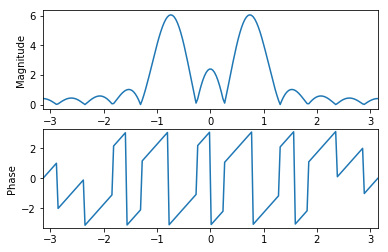

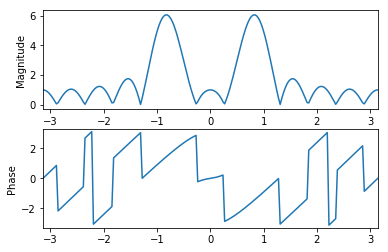

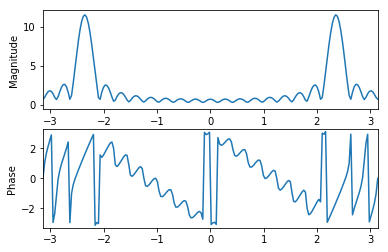

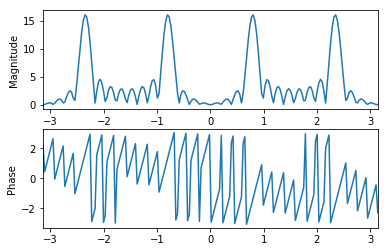

In [4]:
w1 = np.pi/4
w2 = 3 * np.pi/4
sin1 = lambda n: np.sin(w1 * n)
sin2 = lambda n: np.sin(w2 * n)
sin3 = lambda n: sin1(n) + sin2(n)
cos1 = lambda n: np.cos(w1 * n)
s_sin1 = gen_signal(-2, 10, sin1)
s_sin2 = gen_signal(-2, 20, sin2)
s_sin3 = gen_signal(-2, 30, sin3)
s_cos1 = gen_signal(-2, 10, cos1)
DTFT(s_cos1, 200)
DTFT(s_sin1, 200)
DTFT(s_sin2, 200)
DTFT(s_sin3, 200)

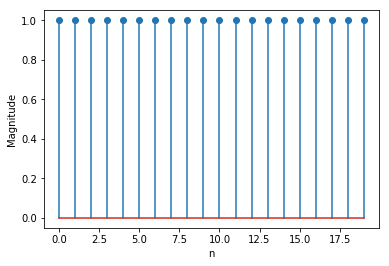

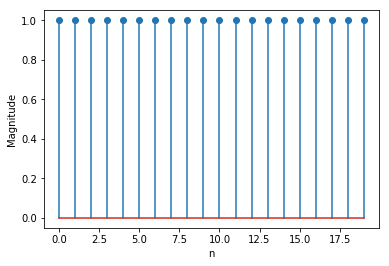

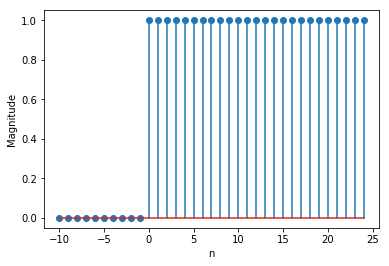

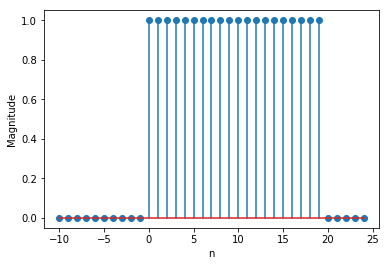

In [5]:
#demonstrates how convolve works with one infinite duration and one finite duration signal
u = gen_signal(0,0, signal=unit_step)
i = gen_signal(0,20, signal=impulse)
c = convolve(u,i)
c2 = convolve(i,u)
graph_signal(c)
graph_signal(c2)
change_range(c, -10, 25)
change_range(c2, -10, 25)
graph_signal(c)
graph_signal(c2)

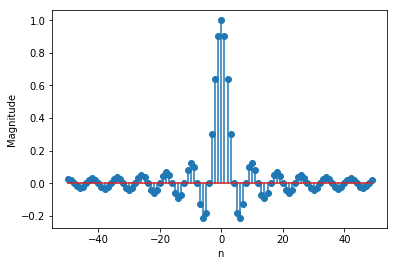

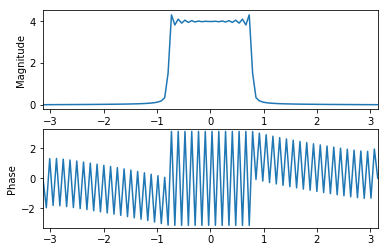

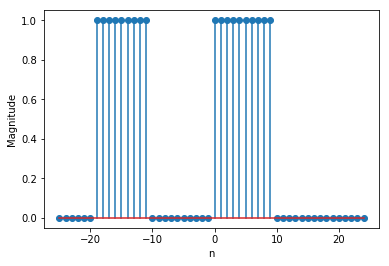

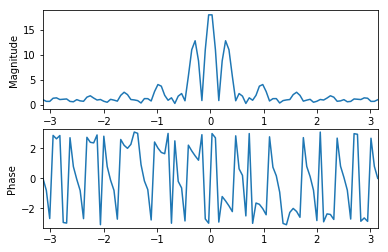

In [6]:
s = gen_signal(-50,50, signal=sinc(np.pi / 4))
graph_signal(s)
DTFT(s)
r = gen_signal(-25, 25, signal=rect(period=20, count=1, t_offset = 0, duty_cycle = .5))
graph_signal(r)
DTFT(r)

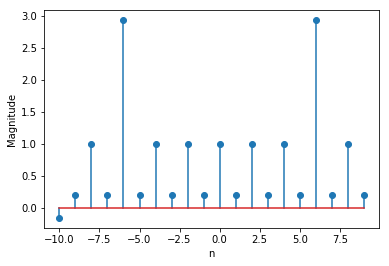

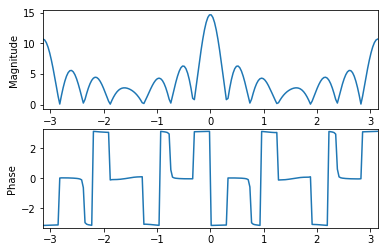

In [7]:
dl = dirichlet(5,np.pi)
s_dl = gen_signal(-10, 10, signal=dl)
graph_signal(s_dl)
DTFT(s_dl, 200)

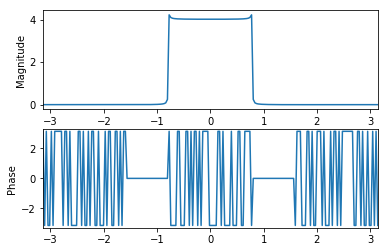

In [8]:
snc = sinc(np.pi/4)
s_snc = gen_signal(-200, 200, snc)
#graph_signal(s_snc)
DTFT(s_snc, 200)

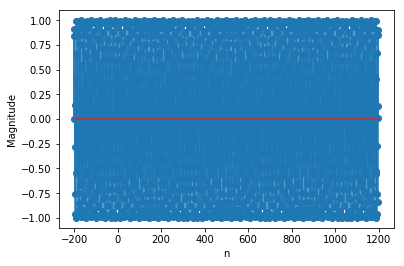

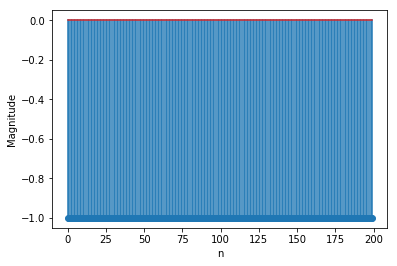

File saved


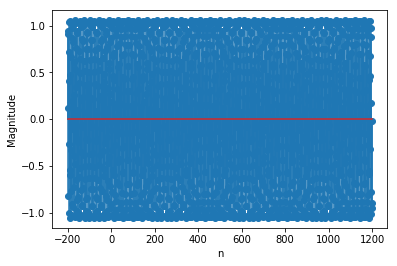

In [9]:
# input signal: start, end, sin function
u1 = gen_signal(-200, 1200, signal=lambda n: np.sin(n))

#first convolution
beta = 5
#filter signal: start, end, beta * delta fn
delta = gen_signal(-1,1,signal=lambda n: beta * impulse(n-2))
u2 = convolve(u,delta)

#add input with the first convolution
u3 = add_signals(u1, u2)

#setup filter
fltr = gen_signal(0, 200, signal = lambda n: unit_step(n-200) - unit_step(n))

#check inputs into final convolution
graph_signal(u3)
graph_signal(fltr)

#output
u4 = convolve(u3, fltr)
save_signal(u4, "signal.csv")
print("File saved")
graph_signal(u4)